In [275]:
import random
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import roc_curve, auc

In [276]:
base_dir = '../data'

train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

In [277]:
from keras.applications import InceptionV3
from keras.models import Model
from keras.regularizers import l2
from keras.callbacks import ReduceLROnPlateau



image_dim = 100 # change as needed

base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(image_dim, image_dim, 3))

for layer in base_model.layers[:100]:
    layer.trainable = True

x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.6)(x)  # Dropout layer to reduce overfitting
x = tf.keras.layers.Dense(1, activation='sigmoid', kernel_regularizer=l2(0.1))(x)  # Regularization to reduce overfitting

model = Model(inputs=base_model.input, outputs=x)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.00001) 

initial_learning_rate = 0.001 


In [278]:
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=initial_learning_rate), # Legacy cuz running on M1/M2 Macbook
              loss='binary_crossentropy',
              metrics = ['accuracy'])

In [279]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(image_dim, image_dim))

test_datagen  = ImageDataGenerator(rescale = 1.0/255)
test_generator =  test_datagen.flow_from_directory(test_dir,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(image_dim, image_dim))

Found 2637 images belonging to 2 classes.
Found 660 images belonging to 2 classes.


In [280]:
history = model.fit(
            train_generator, # pass in the training generator
            steps_per_epoch=50,
            epochs=30,
            validation_data=test_generator, # pass in the validation generator
            validation_steps=20,
            verbose=1
            )

Epoch 1/30
50/50 [==============================] - 20s 341ms/step - loss: 0.8877 - accuracy: 0.7220 - val_loss: 14.6380 - val_accuracy: 0.5625
Epoch 2/30
50/50 [==============================] - 16s 320ms/step - loss: 0.5978 - accuracy: 0.7900 - val_loss: 32.1494 - val_accuracy: 0.6000
Epoch 3/30
50/50 [==============================] - 16s 324ms/step - loss: 0.5429 - accuracy: 0.7910 - val_loss: 87.3353 - val_accuracy: 0.7250
Epoch 4/30
50/50 [==============================] - 16s 315ms/step - loss: 0.5002 - accuracy: 0.7920 - val_loss: 3.5348 - val_accuracy: 0.8000
Epoch 5/30
50/50 [==============================] - 14s 289ms/step - loss: 0.4198 - accuracy: 0.8365 - val_loss: 1.3400 - val_accuracy: 0.8150
Epoch 6/30
50/50 [==============================] - 14s 289ms/step - loss: 0.4376 - accuracy: 0.8230 - val_loss: 0.4321 - val_accuracy: 0.8150
Epoch 7/30
50/50 [==============================] - 17s 345ms/step - loss: 0.3723 - accuracy: 0.8280 - val_loss: 0.5175 - val_accuracy: 0.8

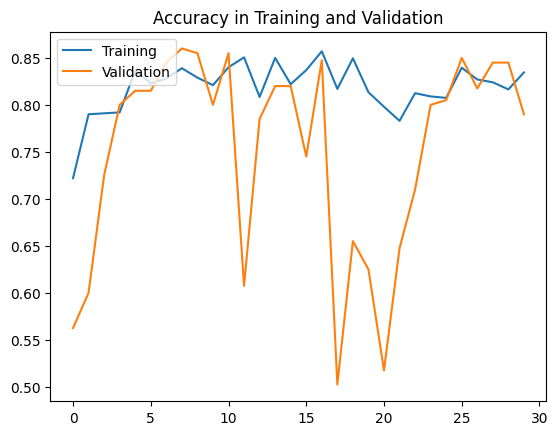

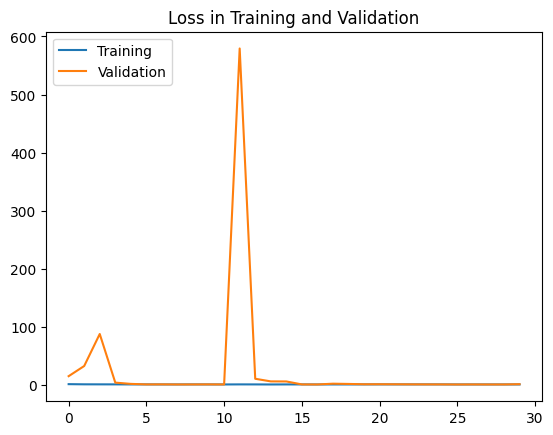

In [281]:
# get the metrics from history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc)) 

# plot accuracy
plt.plot(epochs, acc, label="Training")
plt.plot(epochs, val_acc, label="Validation")
plt.title('Accuracy in Training and Validation')
plt.legend(loc='upper left')
plt.figure()

# plot loss 
plt.plot(epochs, loss, label="Training")
plt.plot(epochs, val_loss, label="Validation")
plt.title('Loss in Training and Validation')
plt.legend(loc='upper left')

In [282]:
# Filepath must end in '/' and contain benign and malignant directories
# Returns a list of n tuples, [(filename, correct_label)...]
# Possible tweak: change filepath instead of returning error?
def random_images(filepath, n):  
    if filepath[-1] != '/':
        print("ERROR: Filepath does not end in '/'.")
        return
    benign_n = random.randint(0, n // 2)
    malig_n = n - benign_n
    benign_dir, malig_dir = os.listdir(filepath + "benign/"), os.listdir(filepath + "malignant/")
    benign_files, malig_files = random.sample(benign_dir, benign_n), random.sample(malig_dir, malig_n)
    output = [("benign/" + filename, "benign") for filename in benign_files]
    output += [("malignant/" + filename, "malignant") for filename in malig_files]
    random.shuffle(output)
    return output
    

In [283]:
filepath = "../data/test/"
class_labels = ['benign', 'malignant']
n = 100

# Create a higher density of threshold values for smoother curves
threshold_range = [0.5, 0.6, 0.7, 0.8, 0.9]
results = []

# Define arrays to store true positive rates and false positive rates for each threshold
tpr_array = []
fpr_array = []
prelim_images = random_images(filepath, n)

for threshold in threshold_range:
    false_positives = 0
    false_negatives = 0
    accurate_ct = 0
    y_true = []  # True labels
    y_scores = []  # Model's scores
    images = prelim_images.copy()

    for file_tuple in images:
        filename, correct_label = file_tuple[0], file_tuple[1]
        img_path = os.path.join(filepath, filename)
        img = image.load_img(img_path, target_size=(image_dim, image_dim))
        x = image.img_to_array(img) / 255
        x = np.expand_dims(x, axis=0)
        images = np.vstack([x])

        classes = model.predict(images, batch_size=10, verbose=0)
        prediction = 1 if classes[0] > threshold else 0  # Use 1 for malignant and 0 for benign

        y_true.append(1 if correct_label == 'malignant' else 0)
        y_scores.append(prediction)

        if prediction == y_true[-1]:
            accurate_ct += 1
        else:
            if prediction == 0 and y_true[-1] == 1:
                false_negatives += 1
            else:
                false_positives += 1

    accuracy = accurate_ct / n
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    results.append((threshold, fpr, tpr, accuracy))
    tpr_array.append(tpr)
    fpr_array.append(fpr)

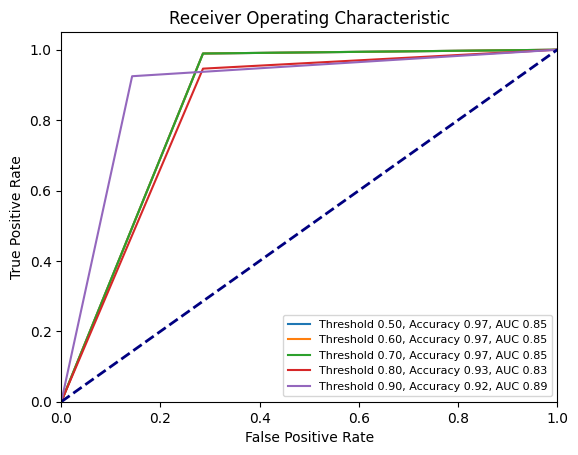

In [284]:
from sklearn.metrics import roc_curve, roc_auc_score, auc

plt.figure()
for threshold, fpr, tpr, accuracy in results:
    roc_auc = auc(fpr, tpr)  # Calculate ROC AUC
    plt.plot(fpr, tpr, label=f'Threshold {threshold:.2f}, Accuracy {accuracy:.2f}, AUC {roc_auc:.2f}')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right', fontsize='8')
plt.show()
